# 0. Setup

In [1]:
import nilearn
import pandas as pd
import numpy as np
import os
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img 


from nilearn import plotting
from nilearn import connectome
from nilearn import datasets
from nilearn import image

from nilearn.regions import connected_label_regions

from nilearn.image import concat_imgs, mean_img, load_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map


c:\Users\sebas\miniconda3\envs\nilearntest\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Set the path to the data directory
src_dir = '../data/derivatives/fc_mvpa'

# Set the participant and session IDs
part_id = 'sub-10'
ses_id = 'ses-01'


# 1. Load Mask / atlas / meta

In [3]:
dataset_ho= datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas_ho_filename = dataset_ho.maps
labels_ho = dataset_ho.labels
number_of_regions_ho = len(labels_ho[1:])
region_labels_ho=connected_label_regions(atlas_ho_filename)


# 2. Load data.

In [4]:
# extract time series from ROIs
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_ho_filename, 
                           standardize="zscore_sample", 
                           standardize_confounds="zscore_sample",
                            memory='nilearn_cache')


In [5]:
data_dir = os.path.join(src_dir, part_id, ses_id)


fn = f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_correlation-matrix.csv'


# Load feature set without index column.
X = pd.read_csv(os.path.join(data_dir, fn), index_col=0)

# Load csv file with targets.
target_set = pd.read_csv(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_targets.csv'))

# Load csv file with groups.
group_set = pd.read_csv(os.path.join(data_dir, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_groups.csv'))

In [6]:
X

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.0,0.472867,0.436031,0.514384,0.538561,0.383304,0.361168,0.270609,0.238606,0.434412,...,0.539531,0.514461,0.389919,0.415573,0.367763,0.087698,0.111545,0.141712,0.455021,1.0
1,1.0,0.349611,0.668151,0.626731,0.602441,0.238092,0.125390,0.648085,0.319852,0.558617,...,0.180248,0.229835,-0.118430,0.037520,0.066224,-0.109608,-0.131272,0.225610,0.430073,1.0
2,1.0,0.437966,0.548335,0.568625,0.320594,0.262169,0.543516,0.671902,0.369025,0.427831,...,0.378764,0.555047,-0.065700,0.387637,0.269983,-0.058294,0.168840,0.260122,0.540543,1.0
3,1.0,0.448497,0.583478,0.519315,0.397270,0.154706,0.509454,0.605059,0.023484,0.464463,...,0.450476,0.618124,-0.053374,0.337868,0.250099,-0.192076,-0.011393,0.058183,0.379482,1.0
4,1.0,0.493920,0.478096,0.503723,0.400250,0.286006,0.582199,0.514801,0.135923,0.271833,...,0.174668,0.388716,0.412687,0.179425,0.104147,-0.088435,0.265158,0.298934,0.473302,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.0,0.398384,0.519039,0.171393,0.237881,0.234724,0.391118,0.484918,0.102054,0.102346,...,0.379838,0.366767,-0.022971,0.216385,0.267523,-0.128571,0.063801,0.148280,0.475625,1.0
72,1.0,0.619738,0.658710,0.591666,0.267869,0.666599,0.756025,0.673688,0.386197,0.678179,...,0.418409,0.627331,0.023029,0.621386,0.514178,0.439777,0.469907,0.517417,0.593605,1.0
73,1.0,0.396131,0.694257,0.660639,0.212614,0.352581,0.512189,0.349390,-0.281890,-0.195372,...,0.661415,0.534743,0.294292,0.525161,0.416039,-0.259563,0.304586,0.069270,0.391460,1.0
74,1.0,0.613916,0.725165,0.453658,0.278723,0.682547,0.661304,0.316044,0.007664,0.054449,...,0.676797,0.738578,-0.034625,0.486314,0.728473,0.058598,0.128654,-0.001377,0.512728,1.0


In [7]:
# Getting the correlation matrix 
partial_correlation_matrix = X.T


In [8]:
# Number of instances (time points) in the data
n_instances = partial_correlation_matrix.shape[1]

# Create an adjacency matrix with time points as the third dimension
correlation_3d = np.zeros((number_of_regions_ho, number_of_regions_ho, n_instances))

# Indices of the lower triangle of the matrix and excluding the diagonal
tril_idx = np.tril_indices(number_of_regions_ho, k=-1)

# Fill the adjacency matrix 
for idx, col in enumerate(partial_correlation_matrix.columns):

    temp_values = partial_correlation_matrix[col].values
    #Fill the lower triangle of the matrix
    matrix_2d = temp_values.reshape((number_of_regions_ho, number_of_regions_ho))
    correlation_3d[:, :, idx] = matrix_2d

In [9]:
# Number of elements in the lower triangle of the matrix
n_lower = len(tril_idx[0]) 

# Create a 2D matrix with the lower triangle of the correlation matrix
flattened_lower_triangle = np.zeros((n_lower, n_instances))

for idx in range(n_instances):
    # Fill the new matrix with 
    flattened_lower_triangle[:, idx] = correlation_3d[:, :, idx][tril_idx]

flattened_lower_triangle.shape

(1128, 76)

In [10]:
df_lower_regions= pd.DataFrame(flattened_lower_triangle.T, columns=[f'{labels_ho[i]} / {labels_ho[j]}' for i, j in zip(tril_idx[0], tril_idx[1])])


In [11]:
df_lower_regions # this is a dataframe with the region labels as columns and the time points as rows

,Frontal Pole / Background,Insular Cortex / Background,Insular Cortex / Frontal Pole,Superior Frontal Gyrus / Background,Superior Frontal Gyrus / Frontal Pole,Superior Frontal Gyrus / Insular Cortex,Middle Frontal Gyrus / Background,Middle Frontal Gyrus / Frontal Pole,Middle Frontal Gyrus / Insular Cortex,Middle Frontal Gyrus / Superior Frontal Gyrus,...,"Supracalcarine Cortex / Temporal Fusiform Cortex, anterior division","Supracalcarine Cortex / Temporal Fusiform Cortex, posterior division",Supracalcarine Cortex / Temporal Occipital Fusiform Cortex,Supracalcarine Cortex / Occipital Fusiform Gyrus,Supracalcarine Cortex / Frontal Operculum Cortex,Supracalcarine Cortex / Central Opercular Cortex,Supracalcarine Cortex / Parietal Operculum Cortex,Supracalcarine Cortex / Planum Polare,Supracalcarine Cortex / Heschl's Gyrus (includes H1 and H2),Supracalcarine Cortex / Planum Temporale
0,0.472867,0.436031,0.433712,0.514384,0.298930,0.234409,0.538561,0.422222,0.298688,0.355118,...,0.445370,0.539531,0.514461,0.389919,0.415573,0.367763,0.087698,0.111545,0.141712,0.455021
1,0.349611,0.668151,0.329324,0.626731,0.426617,0.686683,0.602441,0.367634,0.581698,0.561251,...,0.179311,0.180248,0.229835,-0.118430,0.037520,0.066224,-0.109608,-0.131272,0.225610,0.430073
2,0.437966,0.548335,0.201776,0.568625,0.174270,0.659180,0.320594,0.115109,0.543405,0.426564,...,0.144941,0.378764,0.555047,-0.065700,0.387637,0.269983,-0.058294,0.168840,0.260122,0.540543
3,0.448497,0.583478,0.348565,0.519315,0.473245,0.519277,0.397270,0.350462,0.279547,0.302973,...,0.376591,0.450476,0.618124,-0.053374,0.337868,0.250099,-0.192076,-0.011393,0.058183,0.379482
4,0.493920,0.478096,0.501712,0.503723,0.508312,0.500085,0.400250,0.373563,0.510933,0.417964,...,-0.120594,0.174668,0.388716,0.412687,0.179425,0.104147,-0.088435,0.265158,0.298934,0.473302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.398384,0.519039,0.375862,0.171393,-0.066403,0.147866,0.237881,0.086013,0.123693,-0.085955,...,0.082488,0.379838,0.366767,-0.022971,0.216385,0.267523,-0.128571,0.063801,0.148280,0.475625
72,0.619738,0.658710,0.581271,0.591666,0.331898,0.618991,0.267869,0.265901,0.196553,-0.032595,...,0.248681,0.418409,0.627331,0.023029,0.621386,0.514178,0.439777,0.469907,0.517417,0.593605
73,0.396131,0.694257,0.376891,0.660639,0.172699,0.662892,0.212614,0.155702,0.226223,0.239705,...,-0.030081,0.661415,0.534743,0.294292,0.525161,0.416039,-0.259563,0.304586,0.069270,0.391460
74,0.613916,0.725165,0.529407,0.453658,0.232961,0.379417,0.278723,0.270847,0.532843,0.134713,...,0.514444,0.676797,0.738578,-0.034625,0.486314,0.728473,0.058598,0.128654,-0.001377,0.512728


In [12]:
df_lower  = pd.DataFrame(flattened_lower_triangle.T) # this is the daframe for 

# 3. Classification using scikit routines

In [13]:
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import Pipeline


logo = LeaveOneGroupOut()

In [14]:
X=df_lower.values

In [15]:
y = list(target_set['target'])

# transform the target_set unique strings to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 0 agaisnt all others
# y = np.where(y == 1, 0, 1)

print(y)

[1 8 8 0 0 3 3 2 2 7 7 5 5 6 6 9 9 4 4 1 8 8 3 3 9 9 5 5 4 4 6 6 0 0 7 7 2
 2 1 7 7 9 9 6 6 2 2 5 5 4 4 3 3 0 0 8 8 1 5 5 4 4 3 3 9 9 0 0 2 2 7 7 8 8
 6 6]


In [16]:
runs_group = list(group_set['group'])

print(runs_group)

# unique values in runs_group
print(np.unique(runs_group))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[0 1 2 3]


In [17]:
from sklearn.metrics import roc_auc_score
def roc_auc_score_multiclass(actual_class, pred_class, average, multi_class):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average, multi_class = multi_class)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

### 3.1 Finding the best Hyperparameter

In [18]:
param_grid = [0.1, 1, 10, 100, 1000] #parameters for the SVC

selector = SelectKBest(f_classif)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


accuracy = {}
lr_roc_auc_multiclass  = {} #roc values for multiclass

roc_vals_mc = {}

for i in param_grid:


    # Initialize empty lists for storing metrics per hyperparameter value (dictionary of lists) 
    # Ex: 0.1: [..., ..., ...], 1.0: [..., ..., ...]

    accuracy[i] = []
    lr_roc_auc_multiclass[i] = []
    

    #Define the SVC classifier
    svc_ovr = OneVsRestClassifier(
    Pipeline(
        [
            ("anova", selector),
            ("svc", SVC(kernel="linear", C=i)),
        ]
    )
    )


    for train, test in logo.split(X, y, groups=runs_group): 
        
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        svc_ovr.fit(X_train, y_train)

        # predict the labels
        y_pred = svc_ovr.predict(X_test)

        #y_pred_prob = svc_ovo.predict_proba(X_test)

        # compute the accuracy
        acc = np.mean(y_pred == y_test)
        accuracy[i].append(acc)

        # compute the confusion matrix
        

        # compute the ROC
        roc_vals = roc_auc_score_multiclass(y_test, y_pred, average = 'micro', multi_class = 'ovo')


        lr_roc_auc_multiclass[i].append(list(roc_vals.values()))


        #roc_vals_mc[f] = roc_auc_score(y_test, y_pred_prob, multi_class='ovo', average='weighted')

       
        
print(f'Accuracy: {accuracy}') #accuracy per hyperameter, per fold (0.1: [..., ..., ...], 1.0: [..., ..., ...])
print(f'ROC AUC: {lr_roc_auc_multiclass}') #roc_auc per emotion, per hyperameter and fold (0.1: [[x1, ..., x9], [x1,..., x9], [...]], 1.0: [[x1, ..., x1], [x2,..., x2], [...]])
    



Accuracy: {0.1: [0.05263157894736842, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684], 1: [0.05263157894736842, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684], 10: [0.0, 0.05263157894736842, 0.10526315789473684, 0.15789473684210525], 100: [0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.10526315789473684], 1000: [0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842]}
ROC AUC: {0.1: [[0.6617647058823529, 0.4722222222222222, 0.4411764705882353, 0.47058823529411764, 0.4411764705882353, 0.38235294117647056, 0.4411764705882353, 0.4411764705882353, 0.5, 0.47058823529411764], [0.5, 0.9166666666666667, 0.6323529411764706, 0.4411764705882353, 0.47058823529411764, 0.47058823529411764, 0.47058823529411764, 0.47058823529411764, 0.5, 0.38235294117647056], [0.5, 0.5, 0.6029411764705881, 0.47058823529411764, 0.32352941176470584, 0.6911764705882353, 0.47058823529411764, 0.5, 0.47058823529411764, 0.47058823529411764], [0.4411

In [20]:
# Compute average accuracy and ROC AUC
avg_accuracy = {k: np.mean(v) for k, v in accuracy.items()}
avg_roc_auc = {k: np.mean([np.mean(r) for r in v]) for k, v in lr_roc_auc_multiclass.items()}

# Best based on accuracy or ROC
best_acc_param = max(avg_accuracy, key=avg_accuracy.get)
best_roc_param = max(avg_roc_auc, key=avg_roc_auc.get)

print("Average Accuracy per C:", avg_accuracy)
print("Average ROC AUC per C:", avg_roc_auc)
print(f"Best hyperparameter by Accuracy: {best_acc_param}")
print(f"Best hyperparameter by ROC AUC: {best_roc_param}")

Average Accuracy per C: {0.1: 0.09210526315789473, 1: 0.09210526315789473, 10: 0.07894736842105263, 100: 0.06578947368421052, 1000: 0.05263157894736842}
Average ROC AUC per C: {0.1: 0.5056781045751634, 1: 0.5056781045751634, 10: 0.49244281045751637, 100: 0.4854575163398693, 1000: 0.4784722222222222}
Best hyperparameter by Accuracy: 0.1
Best hyperparameter by ROC AUC: 0.1


## 3.2 Re-run CV with the Best Hyperparameter


In [21]:
# Best hyperparameter based on ROC AUC
from collections import Counter
best_C = max(avg_roc_auc, key=avg_roc_auc.get) 

# number o emotions
n_labels = np.unique(y)
n_labels = len(n_labels)

top_f=10

top_feature_counts = [{} for _ in range(n_labels)] #List of dictionaries for each label

accuracy = {}
lr_roc_auc_multiclass  = {}
cm = {}

f = 0

for train, test in logo.split(X, y, groups=runs_group):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    svc_ovr = OneVsRestClassifier(
        Pipeline([
            ("anova", selector),
            ("svc", SVC(kernel="linear", C=best_C))
        ])
    )

    svc_ovr.fit(X_train, y_train)
    
    for label_idx, estimator in enumerate(svc_ovr.estimators_):
        # Get selected feature indices
        selected_idx = estimator.named_steps["anova"].get_support(indices=True)
        print(f"Selected features for label {label_idx}: {selected_idx}")
        print("")
        coef = estimator.named_steps["svc"].coef_.flatten()
        print(f"Coefficients for label {label_idx}: {coef}")
        print("")

        # Full-length coefficients vector
        full_coef = np.zeros(X.shape[1])
        full_coef[selected_idx] = coef

        # Top-N feature indices by absolute weight
        top_features = np.argsort(np.abs(full_coef))[::-1][:top_f]

        # Manually update counts
        for feat in top_features:
            if feat in top_feature_counts[label_idx]:
                top_feature_counts[label_idx][feat] += 1
            else:
                top_feature_counts[label_idx][feat] = 1




Selected features for label 0: [ 25 420 572 641 683 702 763 772 808 867]

Coefficients for label 0: [-0.03771871 -0.06694063 -0.0595561  -0.05190549 -0.07084563 -0.00101133
 -0.01214419 -0.02249079 -0.08021781 -0.04152601]

Selected features for label 1: [ 248  265  458  617  775  778  999 1093 1103 1115]

Coefficients for label 1: [-0.08689328 -0.03676619 -0.06289064 -0.04568323 -0.05405802 -0.06969951
 -0.06355613 -0.01118486 -0.01215012 -0.09441914]

Selected features for label 2: [ 86 326 341 342 343 431 846 864 869 923]

Coefficients for label 2: [ 0.13333558  0.05757354  0.03199549  0.00068713  0.04307235  0.05286388
  0.0250893   0.10501508 -0.05445393 -0.06623111]

Selected features for label 3: [ 52  70 212 259 280 290 355 382 524 929]

Coefficients for label 3: [-0.04427018 -0.02301998 -0.02819138 -0.01505113 -0.05658069 -0.03467661
 -0.00381546 -0.02398213 -0.02314337  0.05415151]

Selected features for label 4: [ 408  525  783  812 1041 1051 1052 1057 1073 1074]

Coefficien

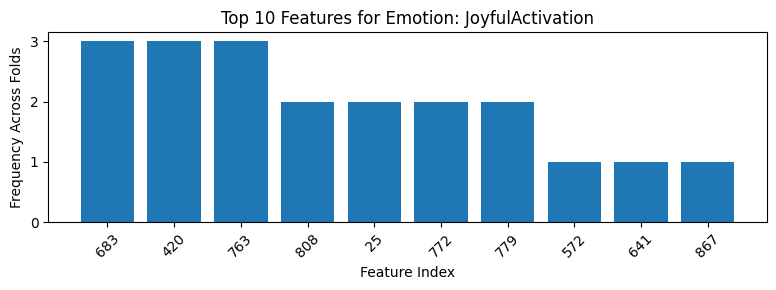

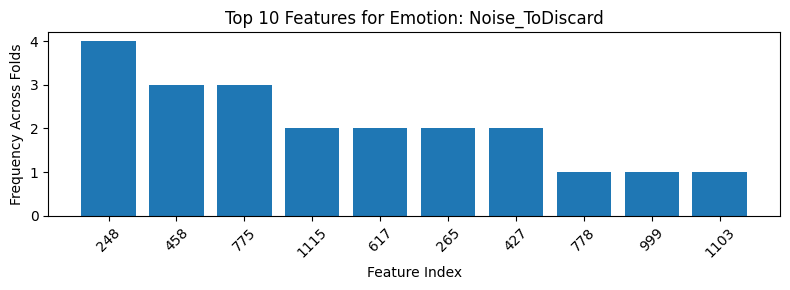

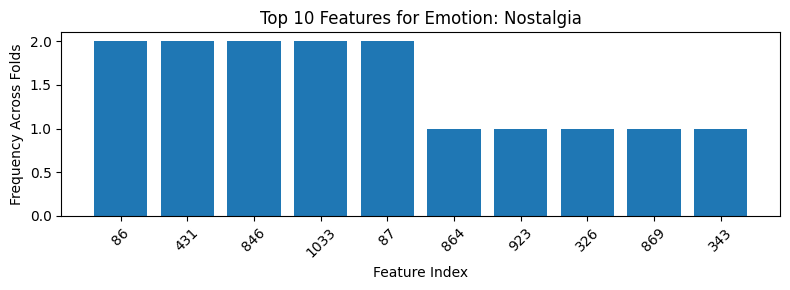

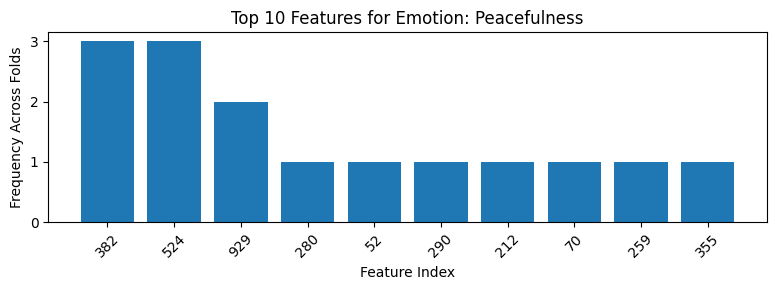

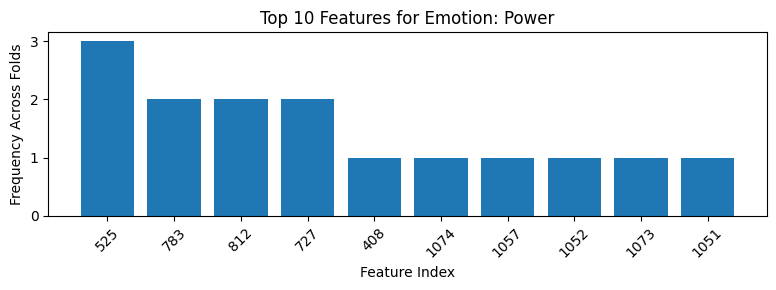

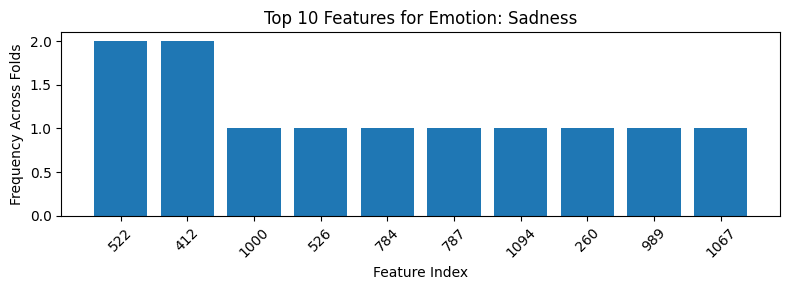

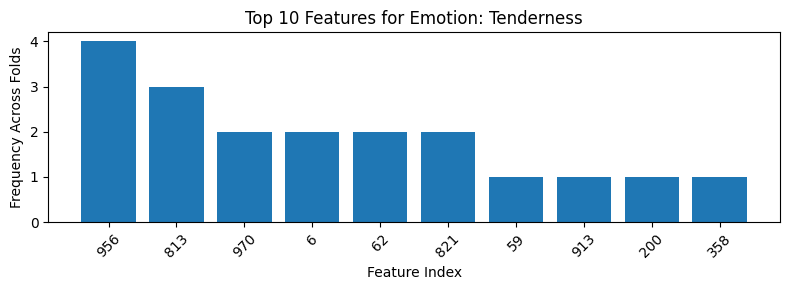

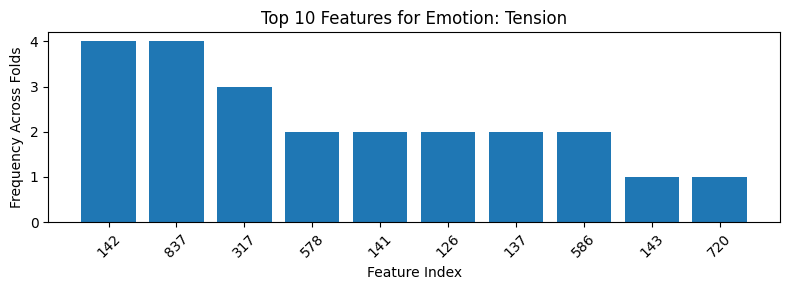

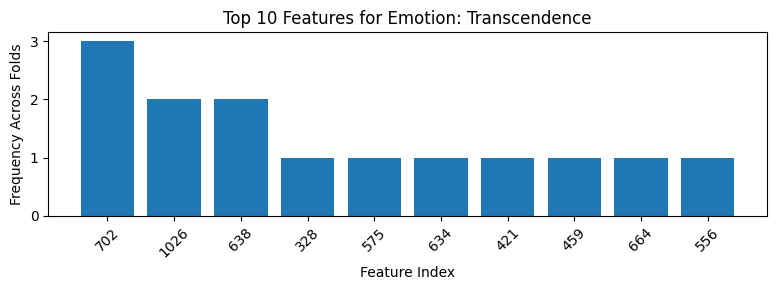

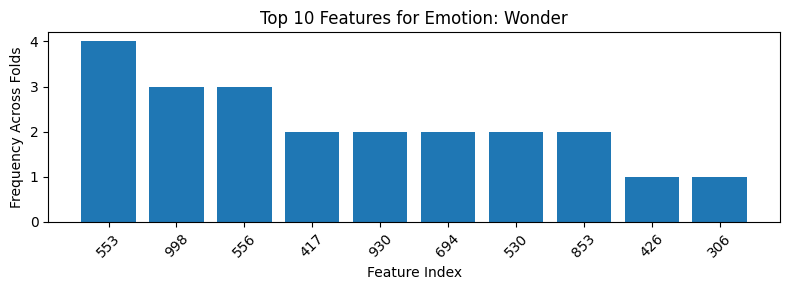

In [22]:
import matplotlib.pyplot as plt
for label_idx, feat_dict in enumerate(top_feature_counts):
    # Sort manually
    sorted_feats = sorted(feat_dict.items(), key=lambda x: x[1], reverse=True)[:top_f]

    features = [f[0] for f in sorted_feats]
    counts = [f[1] for f in sorted_feats]

    plt.figure(figsize=(8, 3))
    plt.bar(range(len(features)), counts, tick_label=features)
    plt.title(f"Top {top_f} Features for Emotion: {le.classes_[label_idx]}")
    plt.xlabel("Feature Index")
    plt.ylabel("Frequency Across Folds")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 3.3 Most Important Features

In [23]:
columns = [f'{labels_ho[i]} / {labels_ho[j]}' for i, j in zip(tril_idx[0], tril_idx[1])]

dict_items([(808, 2), (683, 3), (420, 3), (572, 1), (641, 1), (867, 1), (25, 2), (772, 2), (763, 3), (702, 1), (781, 1), (1058, 1), (626, 1), (11, 1), (779, 2), (301, 1), (383, 1), (806, 1), (1040, 1), (758, 1), (747, 1), (1051, 1), (1037, 1), (734, 1), (1039, 1), (627, 1), (1067, 1), (1117, 1), (1072, 1), (526, 1)])
[683, 420, 763, 808, 25, 772, 779, 572, 641, 867]


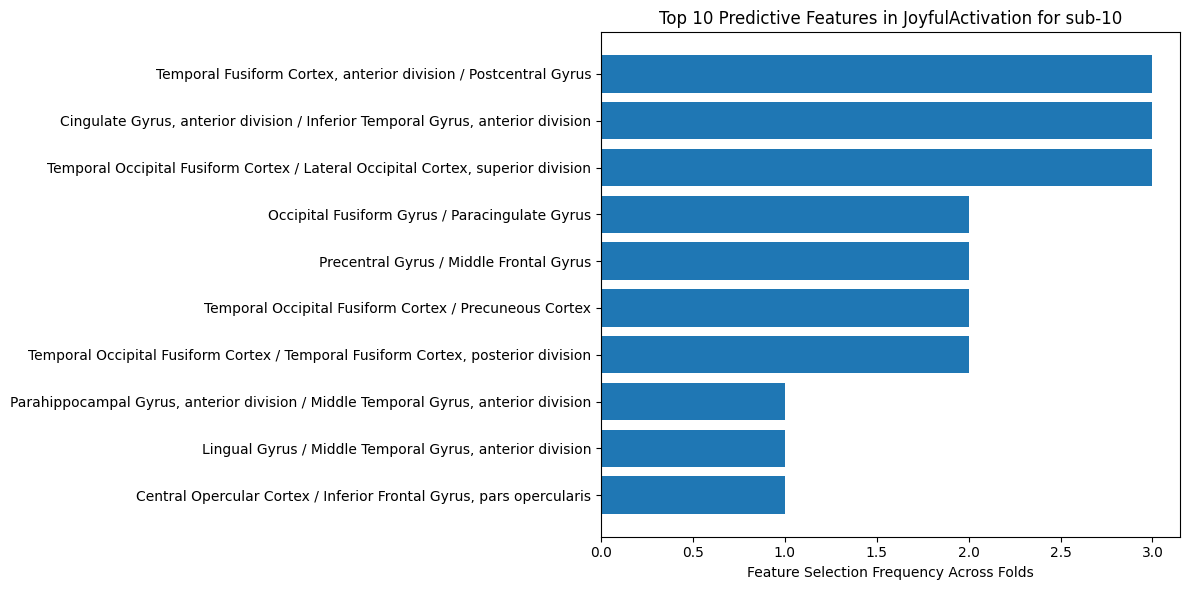

dict_items([(1115, 2), (248, 4), (778, 1), (999, 1), (458, 3), (775, 3), (617, 2), (265, 2), (1103, 1), (1093, 1), (22, 1), (895, 1), (1059, 1), (625, 1), (264, 1), (255, 1), (374, 1), (93, 1), (675, 1), (1116, 1), (464, 1), (427, 2), (612, 1), (611, 1), (758, 1), (554, 1), (583, 1), (1111, 1), (209, 1)])
[248, 458, 775, 1115, 617, 265, 427, 778, 999, 1103]


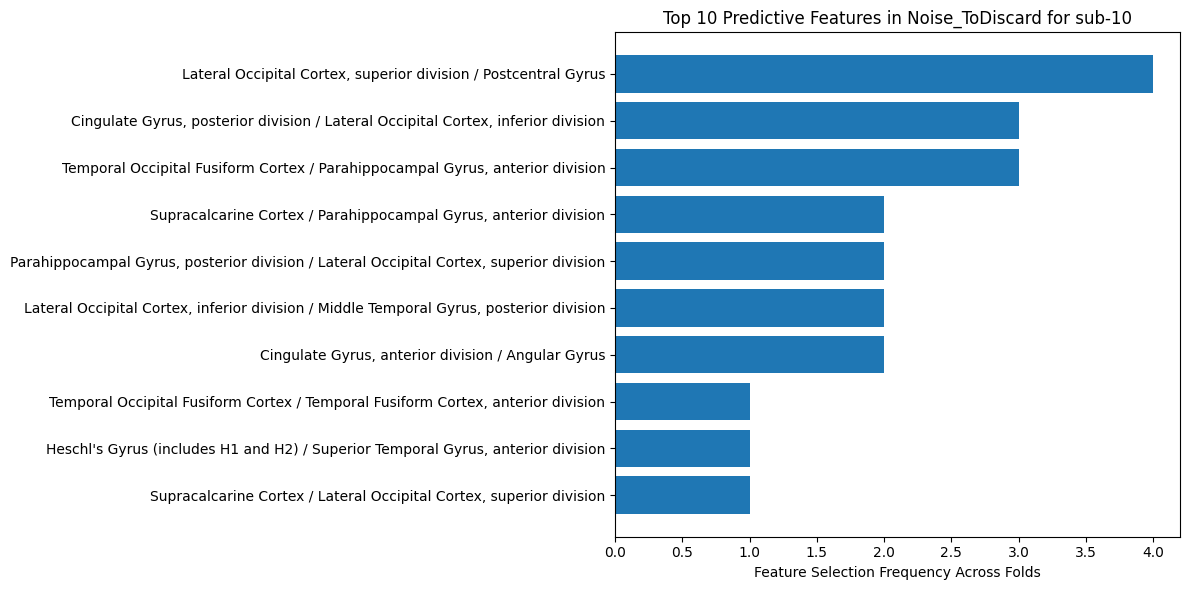

dict_items([(86, 2), (864, 1), (923, 1), (326, 1), (869, 1), (431, 2), (343, 1), (341, 1), (846, 2), (342, 1), (797, 1), (350, 1), (167, 1), (887, 1), (154, 1), (834, 1), (0, 1), (314, 1), (92, 1), (1033, 2), (824, 1), (98, 1), (87, 2), (744, 1), (478, 1), (391, 1), (419, 1), (25, 1), (359, 1), (811, 1), (386, 1), (423, 1), (911, 1), (179, 1), (732, 1)])
[86, 431, 846, 1033, 87, 864, 923, 326, 869, 343]


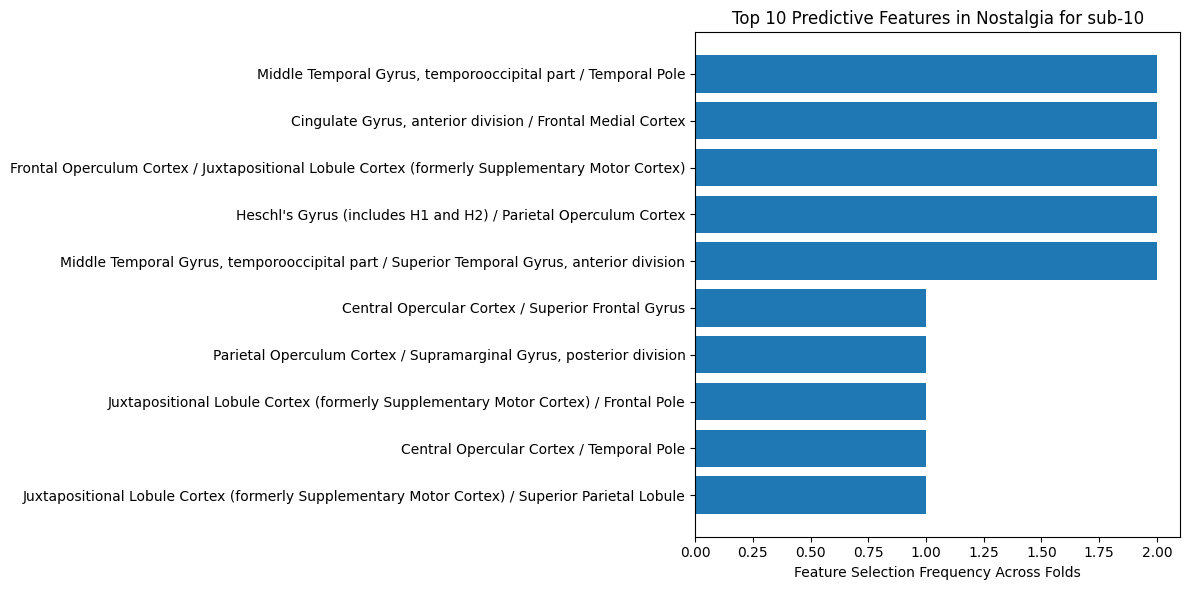

dict_items([(280, 1), (929, 2), (52, 1), (290, 1), (212, 1), (382, 3), (524, 3), (70, 1), (259, 1), (355, 1), (1026, 1), (565, 1), (654, 1), (793, 1), (1027, 1), (1011, 1), (984, 1), (341, 1), (331, 1), (939, 1), (870, 1), (1123, 1), (323, 1), (490, 1), (380, 1), (309, 1), (884, 1), (344, 1), (387, 1), (484, 1), (875, 1), (229, 1), (614, 1), (1100, 1), (250, 1)])
[382, 524, 929, 280, 52, 290, 212, 70, 259, 355]


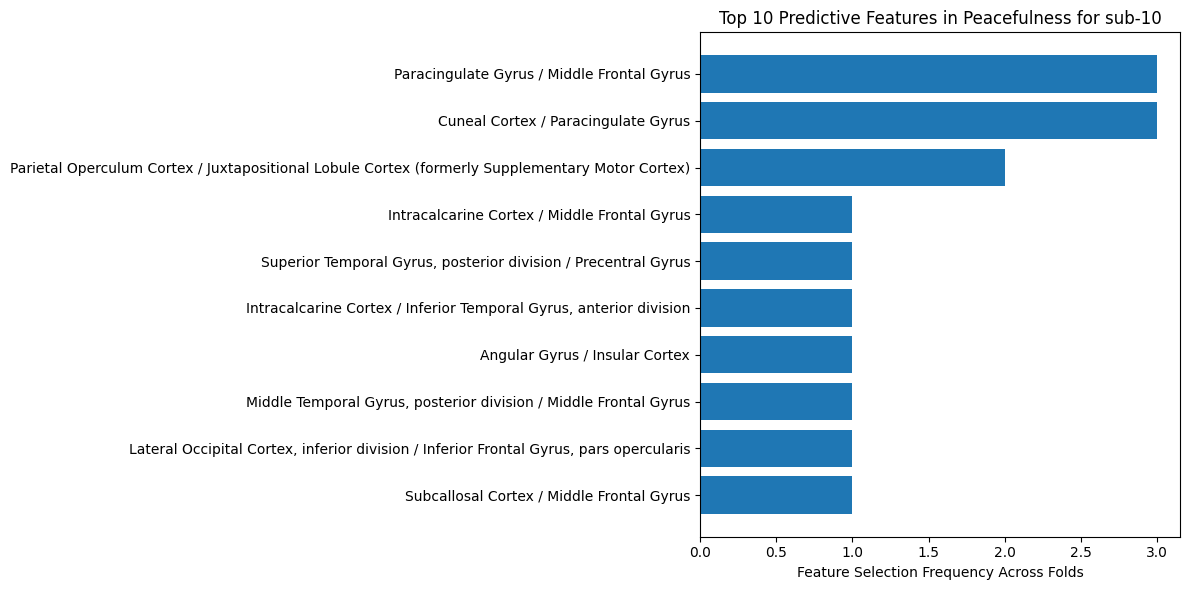

dict_items([(783, 2), (408, 1), (1074, 1), (812, 2), (1057, 1), (1052, 1), (525, 3), (1073, 1), (1051, 1), (1041, 1), (767, 1), (727, 2), (893, 1), (340, 1), (505, 1), (1105, 1), (619, 1), (496, 1), (618, 1), (512, 1), (502, 1), (489, 1), (993, 1), (481, 1), (772, 1), (482, 1), (1011, 1), (1013, 1), (334, 1), (52, 1), (640, 1), (780, 1), (683, 1), (411, 1), (803, 1)])
[525, 783, 812, 727, 408, 1074, 1057, 1052, 1073, 1051]


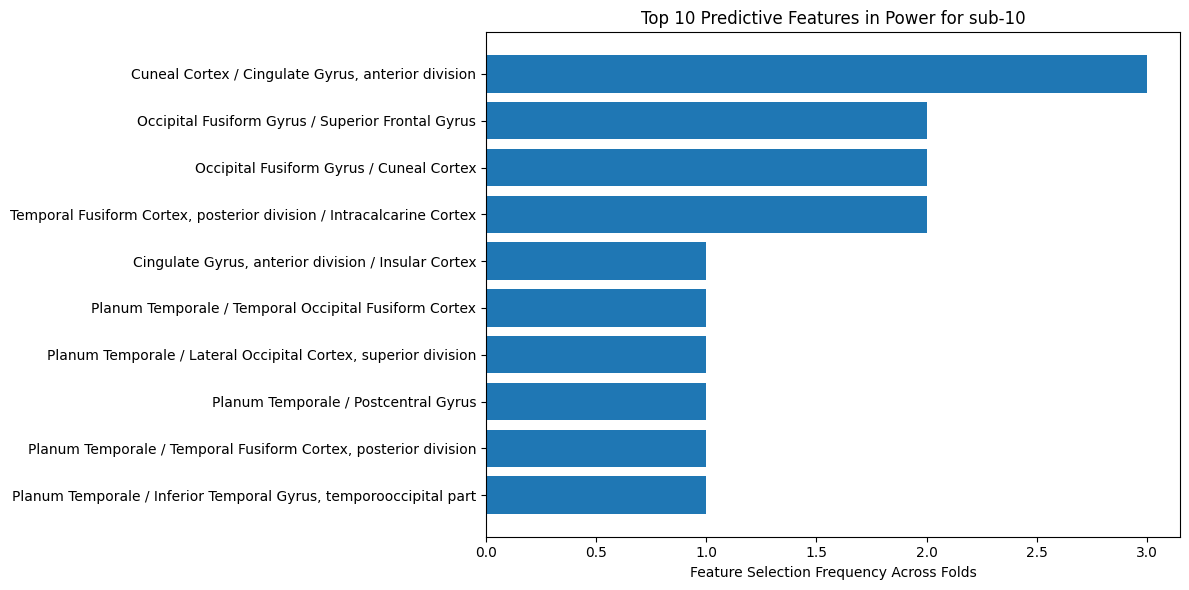

dict_items([(1000, 1), (526, 1), (784, 1), (787, 1), (1094, 1), (522, 2), (260, 1), (989, 1), (1067, 1), (810, 1), (556, 1), (35, 1), (574, 1), (628, 1), (359, 1), (291, 1), (560, 1), (1056, 1), (559, 1), (558, 1), (907, 1), (429, 1), (926, 1), (335, 1), (656, 1), (927, 1), (412, 2), (935, 1), (910, 1), (996, 1), (422, 1), (384, 1), (254, 1), (296, 1), (940, 1), (188, 1), (34, 1), (42, 1)])
[522, 412, 1000, 526, 784, 787, 1094, 260, 989, 1067]


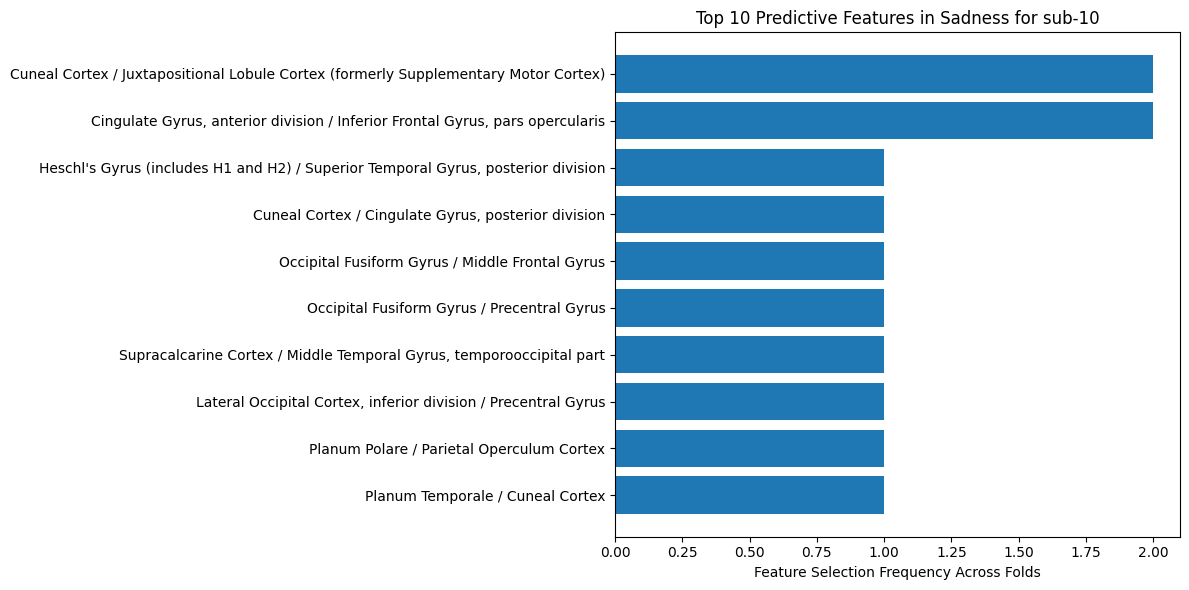

dict_items([(813, 3), (59, 1), (913, 1), (970, 2), (200, 1), (358, 1), (6, 2), (790, 1), (956, 4), (784, 1), (816, 1), (804, 1), (1079, 1), (1075, 1), (1043, 1), (62, 2), (1014, 1), (821, 2), (61, 1), (413, 1), (415, 1), (1001, 1), (21, 1), (1019, 1), (1004, 1), (219, 1), (17, 1), (441, 1), (302, 1), (15, 1), (958, 1)])
[956, 813, 970, 6, 62, 821, 59, 913, 200, 358]


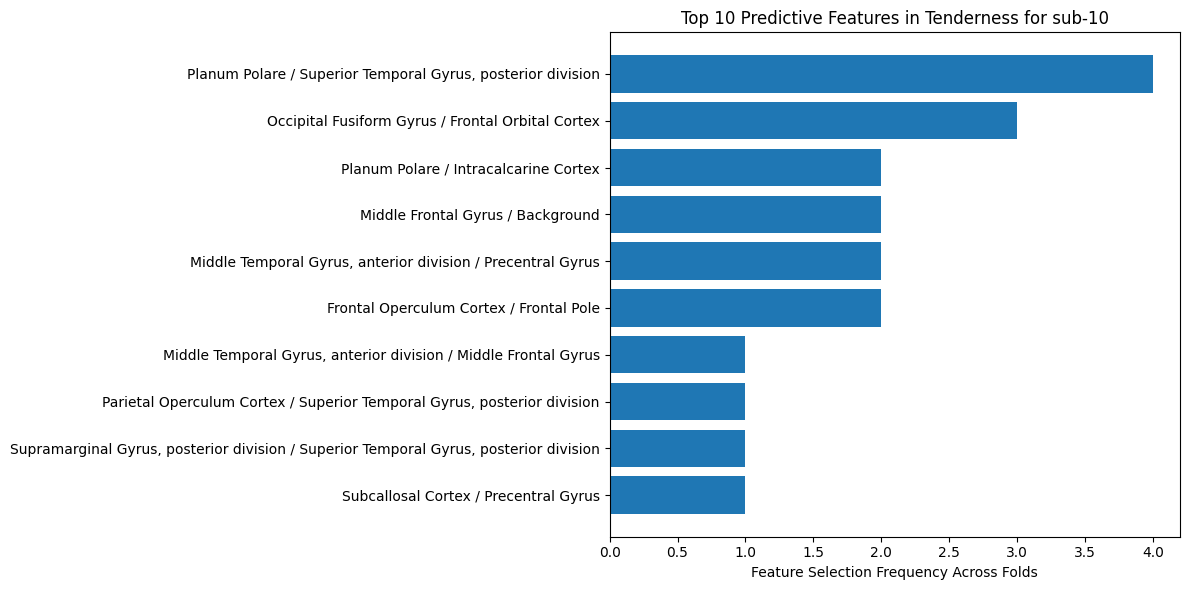

dict_items([(578, 2), (143, 1), (720, 1), (141, 2), (142, 4), (758, 1), (612, 1), (126, 2), (837, 4), (248, 1), (920, 1), (137, 2), (988, 1), (801, 1), (836, 1), (838, 1), (317, 3), (421, 1), (193, 1), (586, 2), (375, 1), (1007, 1), (878, 1), (912, 1), (29, 1), (261, 1), (989, 1)])
[142, 837, 317, 578, 141, 126, 137, 586, 143, 720]


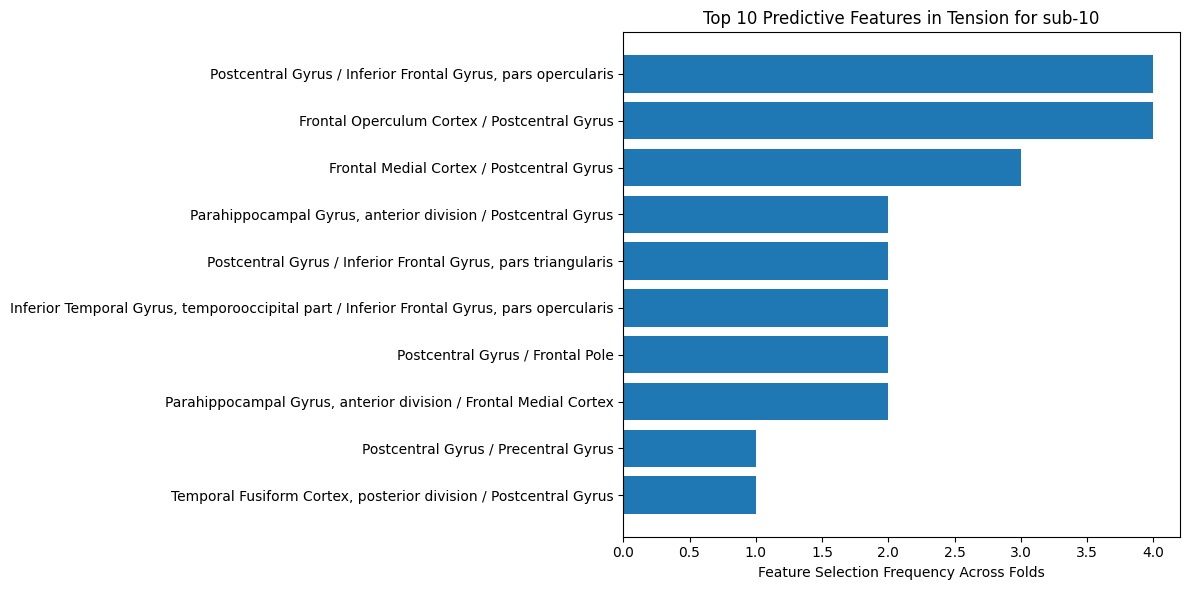

dict_items([(328, 1), (575, 1), (1026, 2), (634, 1), (421, 1), (459, 1), (664, 1), (556, 1), (560, 1), (702, 3), (638, 2), (134, 1), (86, 1), (398, 1), (1021, 1), (224, 1), (707, 1), (385, 1), (1030, 1), (659, 1), (989, 1), (186, 1), (1009, 1), (905, 1), (902, 1), (201, 1), (917, 1), (1095, 1), (1014, 1), (1117, 1), (344, 1), (1048, 1), (554, 1), (28, 1), (1018, 1), (345, 1)])
[702, 1026, 638, 328, 575, 634, 421, 459, 664, 556]


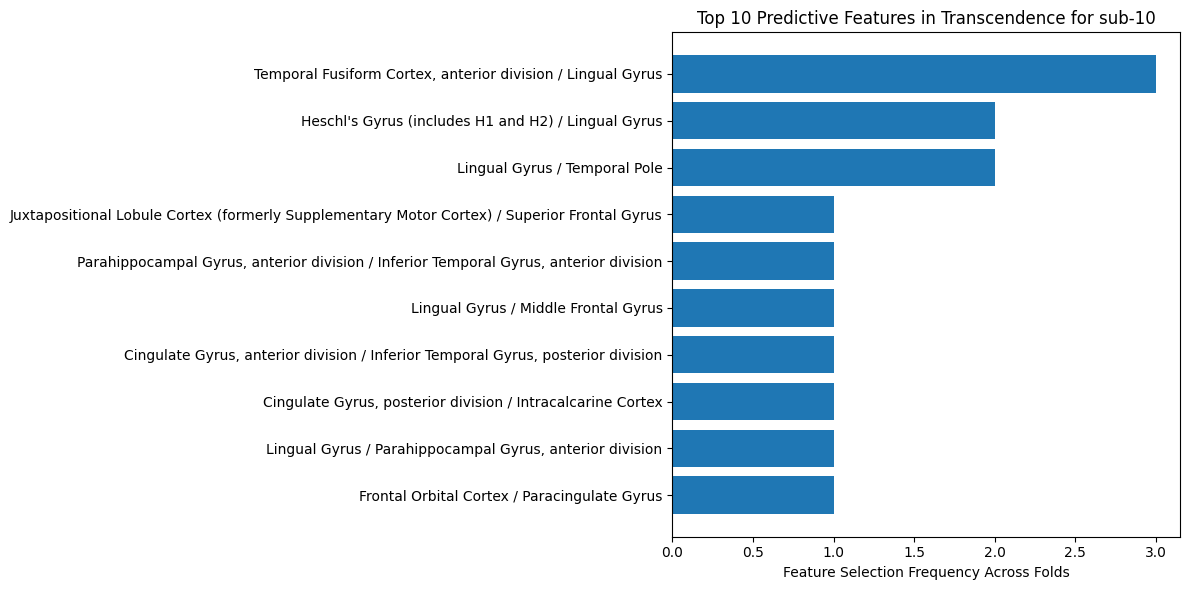

dict_items([(426, 1), (417, 2), (306, 1), (998, 3), (930, 2), (44, 1), (556, 3), (931, 1), (553, 4), (694, 2), (839, 1), (644, 1), (666, 1), (530, 2), (676, 1), (560, 1), (158, 1), (149, 1), (956, 1), (853, 2), (1061, 1), (459, 1), (348, 1), (430, 1), (1048, 1), (558, 1), (531, 1), (528, 1)])
[553, 998, 556, 417, 930, 694, 530, 853, 426, 306]


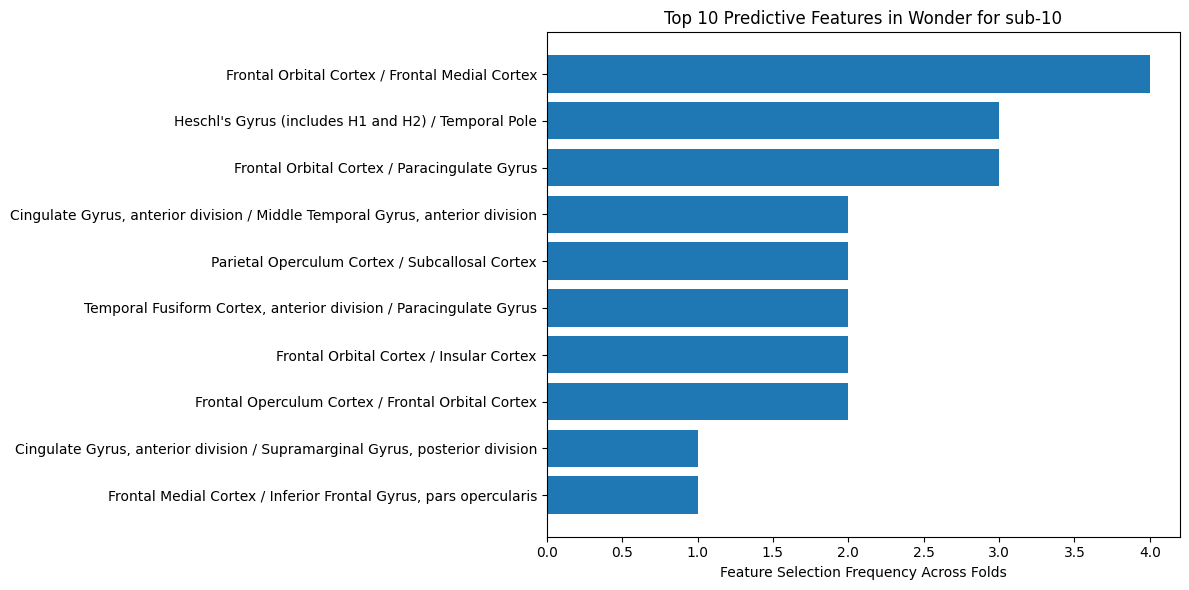

In [24]:
import matplotlib.pyplot as plt

for label_idx, feat_dict in enumerate(top_feature_counts):

    
    
    # Sort manually
    sorted_feats = sorted(feat_dict.items(), key=lambda x: x[1], reverse=True)[:top_f]

    print(feat_dict.items())

    # Get the top features and their counts
    features = [f[0] for f in sorted_feats]

    print(features)
    
    counts = [f[1] for f in sorted_feats]

    named_features = [columns[i] for i in features] # column names of the features


    plt.figure(figsize=(12, 6))
    plt.barh(named_features, counts)
    plt.xlabel("Feature Selection Frequency Across Folds")
    plt.title(f"Top 10 Predictive Features in {le.classes_[label_idx]} for {part_id}")
    plt.gca().invert_yaxis()  # Highest score on top
    plt.tight_layout()
    plt.show()

## 3.3 Mapping the connectivity interactions

### 3.3.1 Creating the atlas on one hemisphere and finding Coordinates

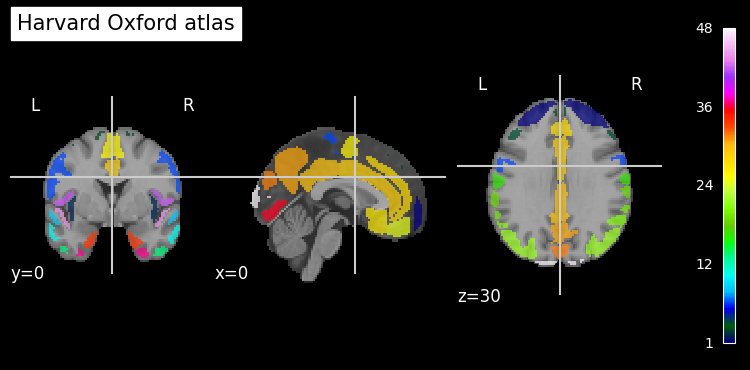

In [25]:
plotting.plot_roi(atlas_ho_filename, title="Harvard Oxford atlas", 
                  display_mode="ortho", cut_coords=(0, 0, 30),
                  colorbar=True, black_bg=True)


In [26]:
# useful for plotting connectivity interactions on glass brain
from nilearn.plotting import (
    find_parcellation_cut_coords,
    plot_connectome,
    show,
)


In [27]:
# get the center of mass of each maps of the atlas using the masks of only the right hemisphere

atlas_ho_data = image.load_img(dataset_ho.maps)


atlas_ho_data = atlas_ho_data.get_fdata()

# print shape of the atlas
print(atlas_ho_data.shape)


# print unique values of the atlas
unique_values = np.unique(atlas_ho_data)
print(unique_values)




# grab center coordinates for atlas labels
coordinates = find_parcellation_cut_coords(dataset_ho.maps)

print(coordinates.shape)

(91, 109, 91)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]
(48, 3)


In [28]:
# print coordinates
print(coordinates)

[[-25.1610225   53.98514311   7.41140485]
 [-37.82129278   1.49809886  -1.39543726]
 [ -9.42361111  24.59027778  56.29166667]
 [-40.43855422  22.45783133  42.41686747]
 [-52.79032258  29.           7.16129032]
 [-53.55731225  14.65612648  13.09090909]
 [-48.0944206   -4.15879828  41.18025751]
 [-40.70137383  11.38250181 -29.80043384]
 [-56.38461538  -1.53846154  -9.38461538]
 [-62.87707641 -29.43521595   3.28903654]
 [-58.78991597  -3.46218487 -23.93277311]
 [-63.49698189 -27.83098592 -11.36418511]
 [-61.1042471  -52.77220077  -0.84942085]
 [-47.88235294  -3.94117647 -40.21568627]
 [-55.29554656 -29.6437247  -26.28340081]
 [-53.34579439 -53.10280374 -18.59813084]
 [-46.11854361 -23.32938188  48.00508044]
 [-30.03225806 -49.19354839  62.91129032]
 [-60.2173913  -32.37888199  37.06832298]
 [-57.74054054 -46.58378378  37.03783784]
 [-54.50292398 -56.44444444  23.78947368]
 [-33.67334594 -73.70132325  38.30548204]
 [-47.12103175 -75.1468254   -1.67063492]
 [ -8.78640777 -75.44660194   8.60

In [29]:
import nibabel as nb

from nilearn.image import get_data, new_img_like
from nilearn.image.resampling import coord_transform

label_image = dataset_ho.maps

# extract the affine matrix of the image
labels_affine = dataset_ho.maps.affine

# generate image coordinates using affine
x, y, z = coord_transform(0, 0, 0, np.linalg.inv(labels_affine))


# generate an separate image for the left hemisphere
# left/right split is done along x-axis

right_hemi = get_data(label_image).copy()
right_hemi[: int(x)] = 0
label_image_right = new_img_like(label_image, right_hemi, labels_affine)

# same for the right hemisphere
left_hemi = get_data(label_image).copy()
left_hemi[int(x) :] = 0
label_image_left = new_img_like(label_image, left_hemi, labels_affine)

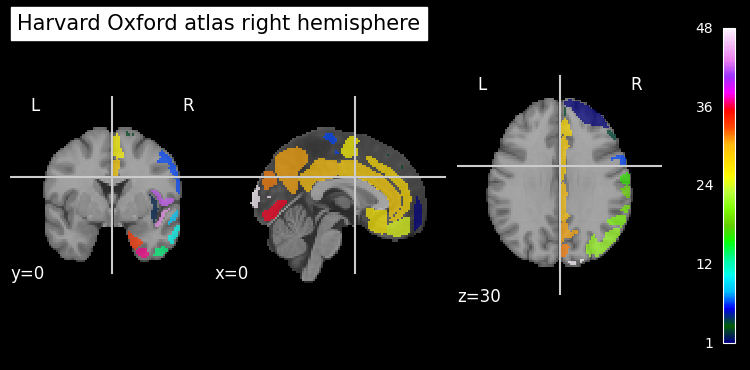

In [30]:
# plot right hemisphere
plotting.plot_roi(label_image_right, title="Harvard Oxford atlas right hemisphere", 
                  display_mode="ortho", cut_coords=(0, 0, 30),
                  colorbar=True, black_bg=True)

In [31]:
coordinates = find_parcellation_cut_coords(
    labels_img=label_image_right, 
)

print(coordinates.shape)

print(coordinates)

(48, 3)
[[ 26.08047913  53.49017406   7.79524612]
 [ 38.68139963   3.19705341  -1.89686924]
 [ 11.31034483  24.4137931   56.99059561]
 [ 41.87480916  22.03053435  44.18625954]
 [ 54.94871795  28.56410256   6.30769231]
 [ 55.25465839  15.8757764   14.63354037]
 [ 37.29233871  -8.21975806  49.04435484]
 [ 40.66090713  13.7350612  -29.91792657]
 [ 58.9787234    1.06382979  -9.27659574]
 [ 61.63190184 -24.45398773   1.57668712]
 [ 59.91752577  -0.68041237 -25.75257732]
 [ 63.74166667 -23.075      -11.76666667]
 [ 61.72460497 -49.03837472   0.67268623]
 [ 46.37974684  -1.24050633 -42.70886076]
 [ 56.875      -23.         -29.0625    ]
 [ 54.96096096 -50.56456456 -17.6996997 ]
 [ 53.25696594 -18.91950464  45.34055728]
 [ 31.57412399 -46.91105121  62.64150943]
 [ 61.51851852 -26.11111111  37.72592593]
 [ 59.26712329 -40.62328767  37.23972603]
 [ 55.07880911 -51.88791594  31.38704028]
 [ 34.74728807 -71.830454    39.12173564]
 [ 48.25079031 -73.04531085  -1.71970495]
 [ 11.03539823 -71.5132743

### 3.3.2 Weighted Connectivity matrix per label


In [34]:
n_nodes = len(coordinates) # len coordinates

columns = [f'{i} / {j}' for i, j in zip(tril_idx[0], tril_idx[1])]
label_weight_matrices = {}

In [36]:
for label_idx, feature in enumerate(top_feature_counts):
    
    # Sort and take top features
    sorted_feats = sorted(feature.items(), key=lambda x: x[1], reverse=True)[:top_f]

    # Filter features with counts ≥ 2
    filtered_feats = [(feat_idx, count) for feat_idx, count in sorted_feats if count >= 2]

    # Create the weight matrix
    weight_matrix = np.zeros((n_nodes, n_nodes))

    for flat_idx, count in filtered_feats:
        i, j = tril_idx[0][flat_idx], tril_idx[1][flat_idx]

        # count as weight
        weight_matrix[i][j] = count
        weight_matrix[j][i] = count  # symmetry (same for both directions)

    
    max_val = weight_matrix.max()
    
    if max_val > 0:
        weight_matrix = weight_matrix / max_val

    label_weight_matrices[label_idx] = weight_matrix



(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)
(48, 48)


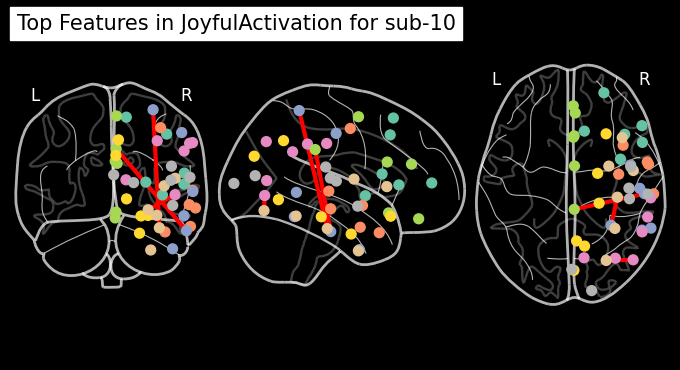

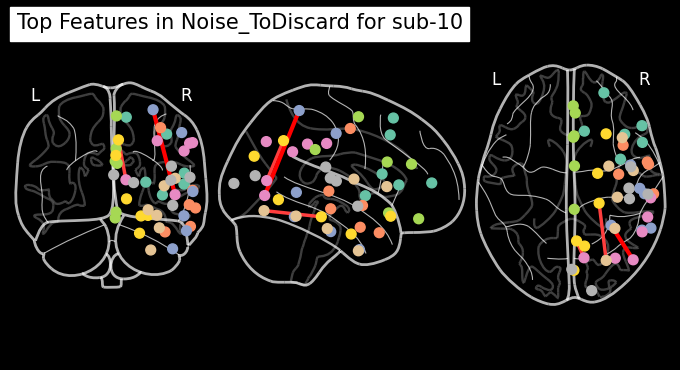

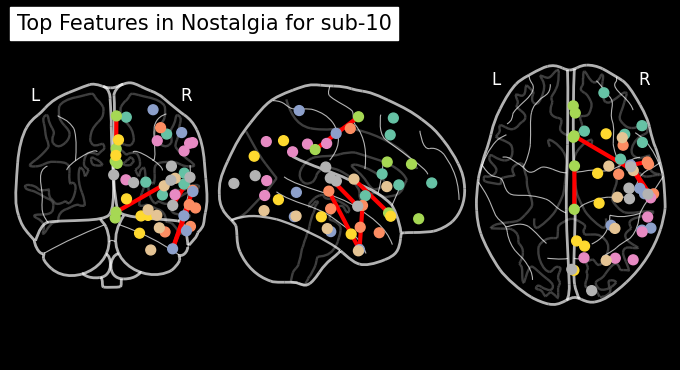

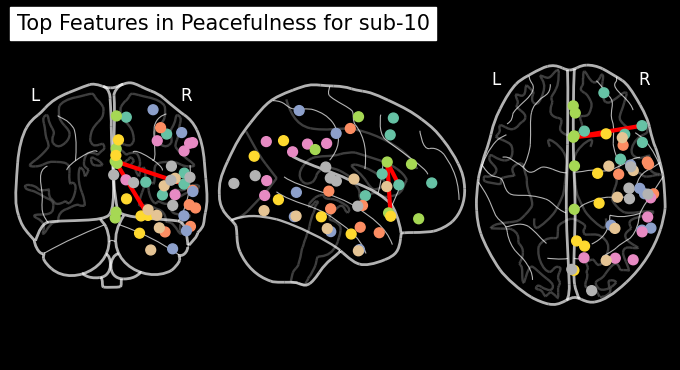

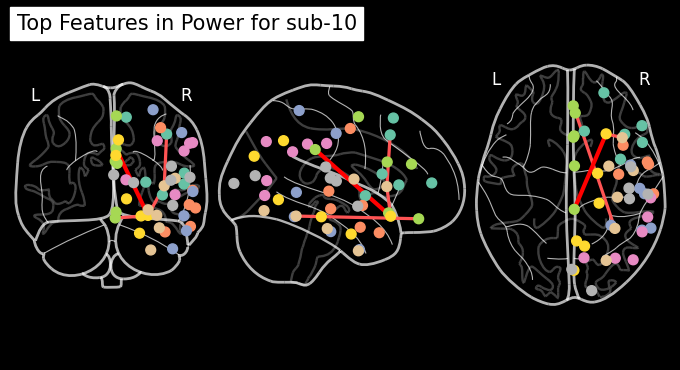

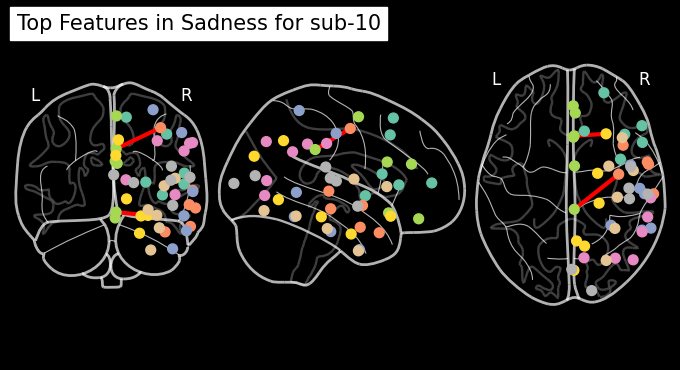

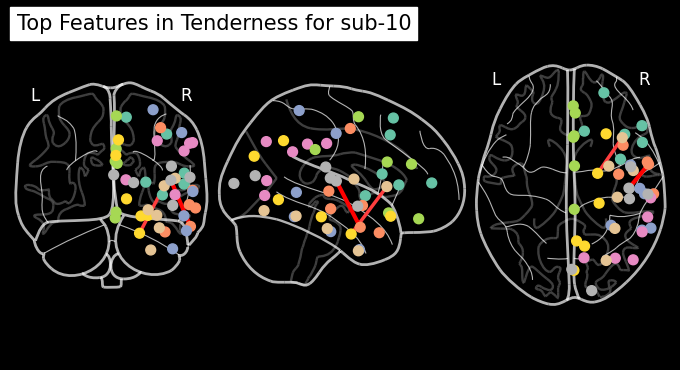

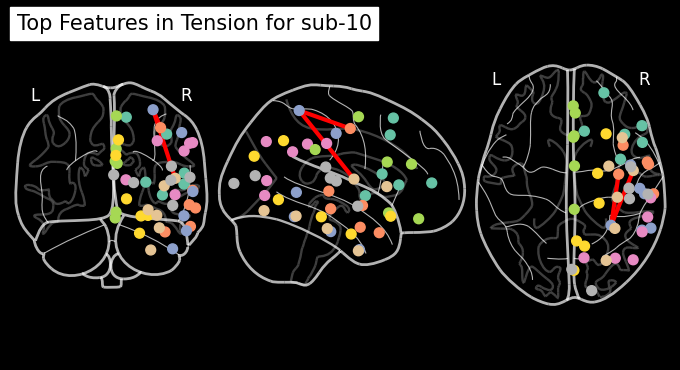

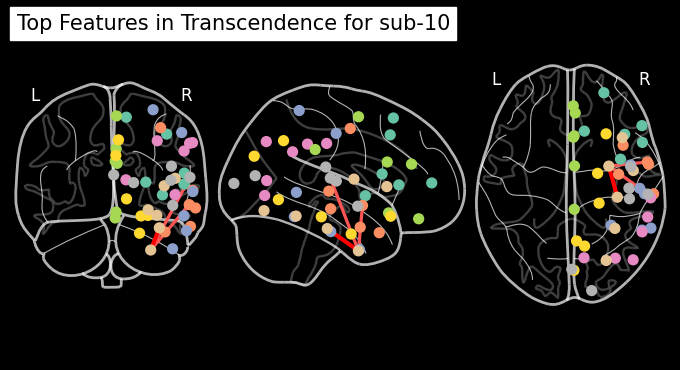

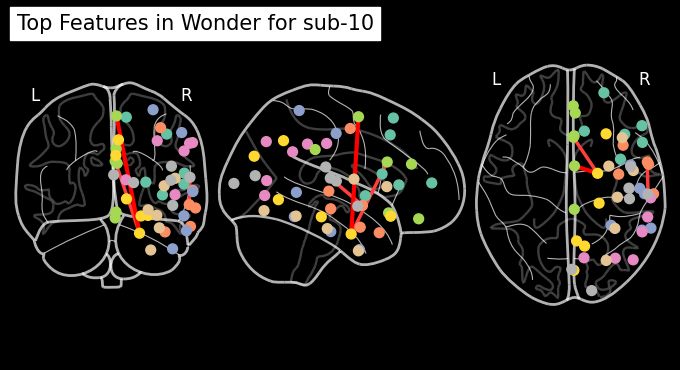

In [37]:
for label_idx, weight_matrix in label_weight_matrices.items():
    print(weight_matrix.shape)
    plotting.plot_connectome(weight_matrix,
                            coordinates, 
                            title=f"Top Features in {le.classes_[label_idx]} for {part_id}",
                            edge_threshold="99.9%",
                            black_bg=True,
                            )
    
   

In [38]:
print(label_weight_matrices.keys())
print(label_weight_matrices[0].shape)
print(top_feature_counts)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
(48, 48)
[{808: 2, 683: 3, 420: 3, 572: 1, 641: 1, 867: 1, 25: 2, 772: 2, 763: 3, 702: 1, 781: 1, 1058: 1, 626: 1, 11: 1, 779: 2, 301: 1, 383: 1, 806: 1, 1040: 1, 758: 1, 747: 1, 1051: 1, 1037: 1, 734: 1, 1039: 1, 627: 1, 1067: 1, 1117: 1, 1072: 1, 526: 1}, {1115: 2, 248: 4, 778: 1, 999: 1, 458: 3, 775: 3, 617: 2, 265: 2, 1103: 1, 1093: 1, 22: 1, 895: 1, 1059: 1, 625: 1, 264: 1, 255: 1, 374: 1, 93: 1, 675: 1, 1116: 1, 464: 1, 427: 2, 612: 1, 611: 1, 758: 1, 554: 1, 583: 1, 1111: 1, 209: 1}, {86: 2, 864: 1, 923: 1, 326: 1, 869: 1, 431: 2, 343: 1, 341: 1, 846: 2, 342: 1, 797: 1, 350: 1, 167: 1, 887: 1, 154: 1, 834: 1, 0: 1, 314: 1, 92: 1, 1033: 2, 824: 1, 98: 1, 87: 2, 744: 1, 478: 1, 391: 1, 419: 1, 25: 1, 359: 1, 811: 1, 386: 1, 423: 1, 911: 1, 179: 1, 732: 1}, {280: 1, 929: 2, 52: 1, 290: 1, 212: 1, 382: 3, 524: 3, 70: 1, 259: 1, 355: 1, 1026: 1, 565: 1, 654: 1, 793: 1, 1027: 1, 1011: 1, 984: 1, 341: 1, 331: 1, 939: 1, 870: 1, 1123: 1, 323: 1,

### 3.3.3 Plotting the Connectome